In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib.image import imread
import seaborn as sns

In [2]:
source_dir = '/home/souvik/GitLab/ML/DATA/face-mask-12k-images-dataset/'
test_path = os.path.join(source_dir, 'Test')
train_path = os.path.join(source_dir, 'Train')
valid_path = os.path.join(source_dir, 'Validation')

In [3]:
x = []
y = []
val_max = []
val_min = []

In [4]:
for folder in os.listdir(test_path):
    for pic in os.listdir(os.path.join(test_path, folder)):
        dim1, dim2, _ = imread(os.path.join(test_path, folder, pic)).shape
        x.append(dim1)
        y.append(dim2)

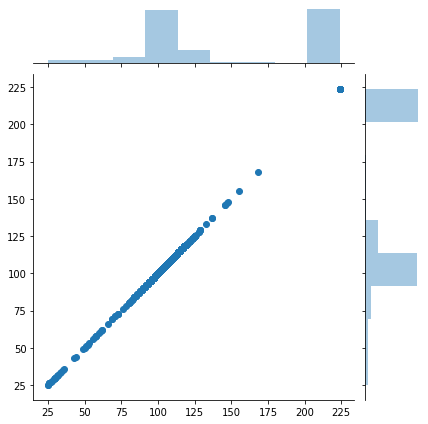

In [5]:
sns.jointplot(x, y)

In [6]:
np.mean(x), np.mean(y)

(151.07762096774192, 151.07762096774192)

In [7]:
np.median(x),  np.median(y)

(115.0, 115.0)

In [8]:
img_shape = (30, 30, 3)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               fill_mode='nearest', # Fill in missing pixels with the nearest filled value
                              brightness_range=(0.2, 1)
                              )

In [11]:
image_gen.flow_from_directory(train_path)

Found 10000 images belonging to 2 classes.


In [12]:
image_gen.flow_from_directory(test_path)

Found 992 images belonging to 2 classes.


In [13]:
image_gen.flow_from_directory(valid_path)

Found 800 images belonging to 2 classes.


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [56]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=img_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(16))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 8)         224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                25104     
_________________________________________________________________
activation_4 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [58]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [59]:
batch_size = 64

In [60]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=img_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 10000 images belonging to 2 classes.


In [61]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=img_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 992 images belonging to 2 classes.


In [62]:
valid_image_gen = image_gen.flow_from_directory(valid_path,
                                               target_size=img_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 800 images belonging to 2 classes.


In [63]:
train_image_gen.class_indices

{'WithMask': 0, 'WithoutMask': 1}

In [65]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
157/157 [==============================] - 14s 90ms/step - loss: 0.1292 - accuracy: 0.9568 - val_loss: 0.1193 - val_accuracy: 0.9637
Epoch 2/20
157/157 [==============================] - 15s 93ms/step - loss: 0.1238 - accuracy: 0.9571 - val_loss: 0.1204 - val_accuracy: 0.9597
Epoch 3/20
157/157 [==============================] - 15s 93ms/step - loss: 0.1263 - accuracy: 0.9581 - val_loss: 0.1161 - val_accuracy: 0.9567
Epoch 4/20
157/157 [==============================] - 14s 90ms/step - loss: 0.1285 - accuracy: 0.9588 - val_loss: 0.1104 - val_accuracy: 0.9637
Epoch 5/20
157/157 [==============================] - 14s 91ms/step - loss: 0.1161 - accuracy: 0.9624 - val_loss: 0.1070 - val_accuracy: 0.9617
Epoch 6/20
157/157 [==============================] - 14s 90ms/step - loss: 0.1136 - accuracy: 0.9613 - val_loss: 0.1152 - val_accuracy: 0.9667
Epoch 7/20
157/157 [==============================] - 14s 90ms/step - loss: 0.1173 - accuracy: 0.9615 - val_loss: 0.1104 - val_accuracy:

In [66]:
metrics = pd.DataFrame(model.history.history)

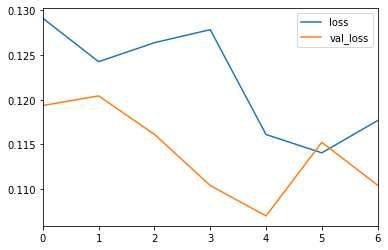

In [67]:
metrics[['loss', 'val_loss']].plot()

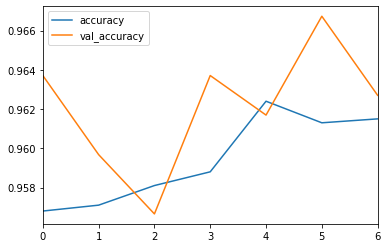

In [68]:
metrics[['accuracy', 'val_accuracy']].plot()

In [69]:
model.evaluate_generator(test_image_gen)

[0.11422962555661798, 0.96370965]

In [70]:
pred = model.predict_generator(test_image_gen)

In [71]:
predictions_test = pred > 0.5

In [72]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_image_gen.classes, predictions_test))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       483
           1       0.95      0.99      0.97       509

    accuracy                           0.96       992
   macro avg       0.97      0.96      0.96       992
weighted avg       0.96      0.96      0.96       992



In [73]:
confusion_matrix(test_image_gen.classes, predictions_test)

array([[454,  29],
       [  7, 502]])

In [74]:
pred_val = model.predict_generator(valid_image_gen)

In [75]:
model.evaluate_generator(valid_image_gen)

[0.08022216134346448, 0.9775]

In [76]:
predictions_val = pred_val > 0.5

In [77]:
print(classification_report(valid_image_gen.classes, predictions_val))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.97      0.99      0.98       400

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



In [78]:
confusion_matrix(valid_image_gen.classes, predictions_val)

array([[387,  13],
       [  5, 395]])

In [79]:
from tensorflow.keras.preprocessing import image

In [80]:
my_image = image.load_img('/home/souvik/GitLab/ML/DATA/face-mask-12k-images-dataset/Validation/WithoutMask/50.png', target_size=img_shape)

In [81]:
my_image

In [82]:
my_image_arr = image.img_to_array(my_image).reshape(1, 30, 30, 3)

In [83]:
model.predict(my_image_arr)

array([[1.]], dtype=float32)

In [84]:
from tensorflow.keras.models import load_model

In [85]:
model.save(os.path.join(os.getcwd(),'mask_id.h5'))

In [86]:
os.getcwd()

'/home/souvik/GitLab/ML/CNNs'

In [87]:
import tensorflow as tf

In [88]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open('mask_id_tiny.tflite', 'wb').write(tflite_model)

2022-08-13 15:42:57.882542: I tensorflow/core/grappler/devices.cc:60] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA support)
2022-08-13 15:42:57.882652: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-08-13 15:42:57.883550: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:716] Optimization results for grappler item: graph_to_optimize
2022-08-13 15:42:57.883573: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:718]   function_optimizer: function_optimizer did nothing. time = 0.002ms.
2022-08-13 15:42:57.883576: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:718]   function_optimizer: function_optimizer did nothing. time = 0ms.
2022-08-13 15:42:57.898289: I tensorflow/core/grappler/devices.cc:60] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA support)
2022-08-13 15:42:57.898388: I tensorflo

28040